### tf.nn.rnn_cell.BasicRNNCellクラスを用いて、単純なRNNのモデルを作成する。

tf.nn.rnn_cell.BasicRNNCellクラスは、セルの内部構造が単層で全結合のニューラルネットワークを表すクラスである。
インスタンス化の際にニューロンの数をnum_units引数に、活性化関数をactivation引数に指定すればよい。activation引数は省略した場合は、tanh関数という-1～1の範囲をとる関数がデフォルトで設定される。

stock_seriesデータセットのデータフレームへの読み込み

In [1]:
import pandas as pd

stock_series = pd.read_csv('NK225_20180905fx2015.csv')

print(stock_series)
print(type(stock_series.index))
print(stock_series['日付'].dtype)

print(stock_series.index[0])
print(type(stock_series.index[0]))

stock_series['日付'] = pd.to_datetime(stock_series['日付'])
print(stock_series['日付'].dtype)

stock_series.set_index('日付', inplace=True)


            日付  start   high    low    end   volume  adjust     USD     GBP  \
0     2015/1/5  17720  17930  17590  17780   727713   17780  120.34  184.19   
1     2015/1/6  17430  17470  17250  17270  1405279   17270  119.38  182.16   
2     2015/1/7  17140  17350  17130  17270   737548   17270  118.84  179.80   
3     2015/1/8  17440  17630  17390  17560   607982   17560  119.47  180.48   
4     2015/1/9  17740  17740  17510  17570   504940   17570  119.87  180.97   
5    2015/1/13  17330  17460  17190  17440   773909   17440  118.02  179.08   
6    2015/1/14  17320  17410  17130  17170   754296   17170  117.65  178.49   
7    2015/1/15  17220  17510  17210  17480   785421   17480  117.71  179.44   
8    2015/1/16  17120  17240  16950  17240  1957143   17240  116.44  176.66   
9    2015/1/19  17390  17420  17280  17380   504886   17380  117.39  177.54   
10   2015/1/20  17440  17740  17440  17740   646051   17740  117.90  177.89   
11   2015/1/21  17680  17710  17560  17660   416808 

stock_seriesデータセットの可視化

C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\plotly\graph_objs\_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\plotly\graph_objs\_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




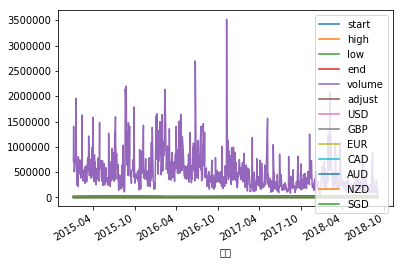

In [2]:
import cufflinks as cf
cf.go_offline()

%matplotlib inline
stock_series.plot()

#subplots=True,
#shape=(len(stock_series.columns), 1),
#shared_xaxes=True

#stock_series.iplot(
#  # 列ごとにグラフを縦に並べて描画する
#  subplots=True,
#  shape=(len(stock_series.columns), 1),
#  # グラフのx軸を共有する
#  shared_xaxes=True
#)



グラフの外観のカスタマイズ  →　エラーが解消できないのでコメントアウト

[]

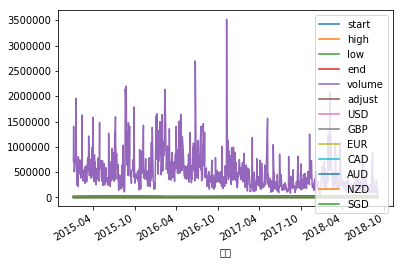

In [3]:
plot_data = stock_series.plot(
#  asFigure=True
#  subplots=True,
#   shared_xaxes=True ,
#  shape=(len(stock_series.columns), 1)
)
# plot_data = stock_series.plot()
#plot_data['layout']['height'] = 1600
#plot_data['layout']['paper_bgcolor'] = '#FFFFFF'
plot_data.plot()

利用する列と順番を再定義してデータフレームを再構築
一部の列のみをデータ項目として利用するには、このコードを記述すればよい。

In [4]:
# 不要列の除去
#target_columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJUST']
#target_columns =  ['start', 'high', 'low', 'end','USD', 'GBP','EUR','CAD','AUD','NZD','SGD']
target_columns =  ['start', 'high', 'low', 'end','adjust','USD']
#target_columns = ['始値', '高値', '安値', '終値', '終値調整']
stock_series = stock_series[target_columns]

データセットを扱うための便利クラス
時系列データの学習では、連続したデータポイントを訓練データとする。連続したデータポイントをランダムに切り出すためのメソッドとしてnext_batchを作成している。next_batchメソッドは、length引数とbatch_size引数をとり、ランダムな「連続したlength分のデータポイント」および「その次のデータポイント」を返す。
学習前に各変数の値を平均0、分散1に変換してスケールを揃える。標準化（Standardization）


In [5]:
import numpy as np

# 乱数シードの初期化（数値は何でもよい）
np.random.seed(12345)

# クラス定義
class TimeSeriesDataSet:

  def __init__(self, dataframe):
    self.feature_count = len(dataframe.columns)
    self.series_length = len(dataframe)
    self.series_data = dataframe.astype('float32')

  def __getitem__(self, n):
    return TimeSeriesDataSet(self.series_data[n])

  def __len__(self):
    return len(self.series_data)

  @property
#  def times(self):
#    return self.series_data.index
 
  def dates(self):
    return self.series_data.index

  def next_batch(self, length, batch_size):
    """
    連続したlength日のデータおよび１日の誤差測定用データを取得する。
    最後の１日は最終出力データ。
    """
    max_start_index = len(self) - length
    design_matrix = []
    expectation = []
    while len(design_matrix) < batch_size:
      start_index = np.random.choice(max_start_index)
      end_index = start_index + length + 1
      values = self.series_data[start_index:end_index]
      if (values.count() == length + 1).all():  # 切り出したデータ中に欠損値がない
        train_data = values[:-1]
        true_value = values[-1:]
        design_matrix.append(train_data.as_matrix())
        expectation.append(np.reshape(true_value.as_matrix(), [self.feature_count]))
    return np.stack(design_matrix), np.stack(expectation)

  def append(self, data_point):
    dataframe = pd.DataFrame(data_point, columns=self.series_data.columns)
    self.series_data = self.series_data.append(dataframe)

  def tail(self, n):
    return TimeSeriesDataSet(self.series_data.tail(n))

  def as_array(self):
    return np.stack([self.series_data.as_matrix()])

  def mean(self):
    return self.series_data.mean()

  def std(self):
    return self.series_data.std()

  def standardize(self, mean=None, std=None):
    if mean is None:
      mean = self.mean()
    if std is None:
      std = self.std()
    return TimeSeriesDataSet((self.series_data - mean) / std)

データセットを訓練（train）データと精度検証用のテスト（test）データに分離

2018年6月1日より前のデータのみを訓練（train）時に利用し、以降のデータは予測の際にのみ利用する精度検証用のテスト（test）データとする。
訓練データから精度検証（validation）用データを切り分けずに、テストデータのみを精度検証に利用する。

In [6]:
dataset = TimeSeriesDataSet(stock_series)

train_dataset = dataset[dataset.dates < '2018-06-01']
test_dataset = dataset[dataset.dates >= '2018-06-01']


TensroFlowのセッションを開始し、各種パラメーターと、データ入力用のプレースホルダーを定義

In [7]:
import tensorflow as tf
sess = tf.InteractiveSession()

# 再現性の確保のために乱数シードを固定
tf.set_random_seed(12345)

# パラメーター
# 学習日数長さ  72 --->30
SERIES_LENGTH = 30
# 特徴量数
FEATURE_COUNT = dataset.feature_count

# 入力（placeholderメソッドの引数は、データ型、テンソルのサイズ）
# 訓練データ
x = tf.placeholder(tf.float32, [None, SERIES_LENGTH, FEATURE_COUNT])
# 教師データ
y = tf.placeholder(tf.float32, [None, FEATURE_COUNT])

RNNのセルを定義
RNNのセルには、tf.rnn.rnn_cell.BasicRNNCellクラスを用いる。
num_units引数に20（ニューロン）を指定し、activation引数は指定せずデフォルトのまま（tanh関数）とする。
RNNセルは再帰的にネットワークを構築するが、一番上のセル（tf.shape(x)[0]）に対する入力が必要となる。つまりRNNセルの初期状態（initial_state）について定義する。ここでは単純にゼロの初期状態を与えるものとし、BasicRNNCellクラスのzero_stateメソッドを用いる。
ネットワークの入出力はtf.nn.dynamic_rnnメソッドを使う。tf.nn.dynamic_rnn関数の戻り値は、各セルのニューロンの状態（outputs）と、最後のセルのニューロンの状態（last_state）である。これらを用いて、おのおのの出力を求めることができる。


In [8]:
# RNNセルの作成
cell = tf.nn.rnn_cell.BasicRNNCell(20)
#　RNNの代わりにLSTMを試したがエラーとなった。引数を確認する。
#cell = tf.nn.rnn_cell.BasicLSTMCell(20,forget_bias=1.0)   　
#cell = tf.nn.rnn_cell.BasicLSTMCell(20)   　
#  ValueError: Shape must be rank 2 but is rank 3 for 'MatMul' (op: 'MatMul') with input shapes: [2,?,20], [20,6].

initial_state = cell.zero_state(tf.shape(x)[0], dtype=tf.float32)
outputs, last_state = tf.nn.dynamic_rnn(cell, x, initial_state=initial_state, dtype=tf.float32)


全結合と最適化
最終的な出力――すなわち入力のSERIES_LENGTH(=30)の次の日――の予測値を、最適化に利用する

In [9]:
# 全結合
# 重み
w = tf.Variable(tf.zeros([20, FEATURE_COUNT]))
# バイアス
b = tf.Variable([0.1] * FEATURE_COUNT)
# 最終出力（予測）
prediction = tf.matmul(last_state, w) + b

# 損失関数（平均絶対誤差：MAE）と最適化（Adam）
loss = tf.reduce_mean(tf.map_fn(tf.abs, y - prediction))
optimizer = tf.train.AdamOptimizer().minimize(loss)

RNNによる学習を実行する

In [10]:
# バッチサイズ
BATCH_SIZE = 16
# 学習回数
NUM_TRAIN =  10000
# 学習中の出力頻度
OUTPUT_BY = 500

# 標準化
train_mean = train_dataset.mean()
train_std = train_dataset.std()
standardized_train_dataset = train_dataset.standardize()

# 学習の実行
sess.run(tf.global_variables_initializer())
for i in range(NUM_TRAIN):
  batch = standardized_train_dataset.next_batch(SERIES_LENGTH, BATCH_SIZE)
  mae, _ = sess.run([loss, optimizer], feed_dict={x: batch[0], y: batch[1]})
  if i % OUTPUT_BY == 0:
    print('step {:d}, error {:.5f}'.format(i, mae))
  
  if i == NUM_TRAIN-1:
    print('CALC END  step {:d}, error {:.5f}'.format(i, mae))
    

C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:42: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:43: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



step 0, error 0.87246
step 500, error 0.07994
step 1000, error 0.07661
step 1500, error 0.06656
step 2000, error 0.08501
step 2500, error 0.08696
step 3000, error 0.08089
step 3500, error 0.05035
step 4000, error 0.08980
step 4500, error 0.07458
step 5000, error 0.06277
step 5500, error 0.06215
step 6000, error 0.08255
step 6500, error 0.06512
step 7000, error 0.07068
step 7500, error 0.06487
step 8000, error 0.07129
step 8500, error 0.09093
step 9000, error 0.07567
step 9500, error 0.05305
CALC END  step 9999, error 0.04677


予測を行い、各日付の結果値を変数predict_stock_seriesに保存するコード
学習済みのモデルを用いて予測を行う。
予測は、「予測対象となる日付の前３０日分のデータを入力データとして予測する」という操作を繰り返して行う。

In [11]:
def rnn_predict(input_dataset):
  # 標準化
  previous = TimeSeriesDataSet(input_dataset).tail(SERIES_LENGTH).standardize(mean=train_mean, std=train_std)
  
# 予測対象の時刻
#predict_time = previous.times[-1] + np.timedelta64(1, 'h')

  # 予測対象の日付　　predict_time
  import datetime
  from dateutil.relativedelta import relativedelta
  predict_time = previous.dates[-1] +  datetime.timedelta(days=1)  
  
  print('predict_time:',predict_time)  
    
  # 予測
  batch_x = previous.as_array()
  predict_data = prediction.eval({x: batch_x})

  # 結果のデータフレームを作成
  df_standardized  = pd.DataFrame(predict_data, columns=input_dataset.columns, index=[predict_time])
  # 標準化の逆操作
  return train_mean + train_std * df_standardized

predict_stock_series = pd.DataFrame([], columns=stock_series.columns)
for current_time in test_dataset.dates:
  # < から　<= と　等号をつけることによって、1日先を予測
  #predict_result = rnn_predict(stock_series[stock_series.index < current_time])
  #current_time_plus = current_time.dates[-1] +  datetime.timedelta(days=1)    
  #print('current_time,test_dataset.dates:',current_time,test_dataset.dates)  
  predict_result = rnn_predict(stock_series[stock_series.index <= current_time])
  predict_stock_series = predict_stock_series.append(predict_result)

predict_time: 2018-06-02 00:00:00
predict_time: 2018-06-05 00:00:00
predict_time: 2018-06-06 00:00:00
predict_time: 2018-06-07 00:00:00
predict_time: 2018-06-08 00:00:00
predict_time: 2018-06-09 00:00:00
predict_time: 2018-06-12 00:00:00
predict_time: 2018-06-13 00:00:00
predict_time: 2018-06-14 00:00:00
predict_time: 2018-06-15 00:00:00
predict_time: 2018-06-16 00:00:00
predict_time: 2018-06-19 00:00:00
predict_time: 2018-06-20 00:00:00
predict_time: 2018-06-21 00:00:00
predict_time: 2018-06-22 00:00:00


C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:54: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



predict_time: 2018-06-23 00:00:00
predict_time: 2018-06-26 00:00:00
predict_time: 2018-06-27 00:00:00
predict_time: 2018-06-28 00:00:00
predict_time: 2018-06-29 00:00:00
predict_time: 2018-06-30 00:00:00
predict_time: 2018-07-03 00:00:00
predict_time: 2018-07-04 00:00:00
predict_time: 2018-07-05 00:00:00
predict_time: 2018-07-06 00:00:00
predict_time: 2018-07-07 00:00:00
predict_time: 2018-07-10 00:00:00
predict_time: 2018-07-11 00:00:00
predict_time: 2018-07-12 00:00:00
predict_time: 2018-07-13 00:00:00
predict_time: 2018-07-14 00:00:00
predict_time: 2018-07-18 00:00:00
predict_time: 2018-07-19 00:00:00
predict_time: 2018-07-20 00:00:00
predict_time: 2018-07-21 00:00:00
predict_time: 2018-07-24 00:00:00
predict_time: 2018-07-25 00:00:00
predict_time: 2018-07-26 00:00:00
predict_time: 2018-07-27 00:00:00
predict_time: 2018-07-28 00:00:00
predict_time: 2018-07-31 00:00:00
predict_time: 2018-08-01 00:00:00
predict_time: 2018-08-02 00:00:00
predict_time: 2018-08-03 00:00:00
predict_time: 

予測結果を可視化するサンプルコード

                   start          high           low           end  \
2018-06-02  22962.625000  23087.525391  22851.638672  22973.970703   
2018-06-05  23340.927734  23437.179688  23242.201172  23344.425781   
2018-06-06  23344.912109  23413.921875  23232.179688  23326.921875   
2018-06-07  23480.677734  23549.363281  23362.167969  23455.757812   
2018-06-08  23659.763672  23724.470703  23549.169922  23633.333984   
2018-06-09  23527.750000  23621.320312  23403.212891  23517.648438   
2018-06-12  23671.384766  23739.779297  23550.876953  23639.027344   
2018-06-13  23678.062500  23772.201172  23561.244141  23672.037109   
2018-06-14  23773.449219  23850.117188  23662.923828  23762.562500   
2018-06-15  23612.330078  23692.441406  23486.244141  23597.429688   
2018-06-16  23701.439453  23778.572266  23583.365234  23682.158203   
2018-06-19  23498.771484  23591.240234  23372.476562  23487.992188   
2018-06-20  23172.324219  23300.291016  23035.734375  23175.070312   
2018-06-21  23421.96

6 end
6 adjust
6 USD


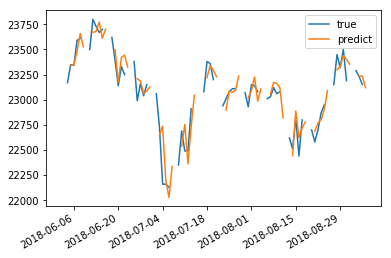

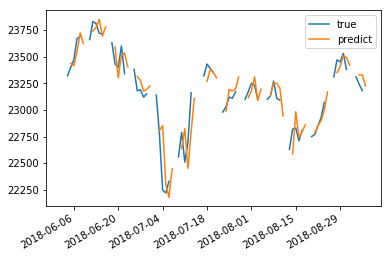

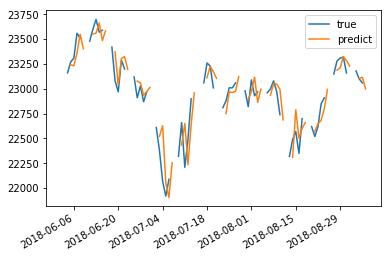

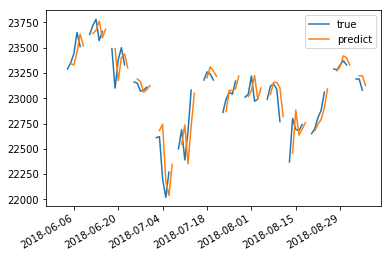

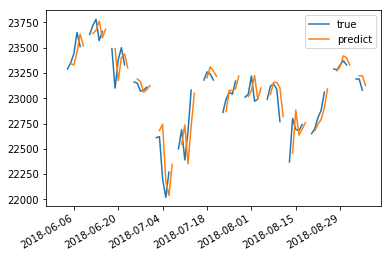

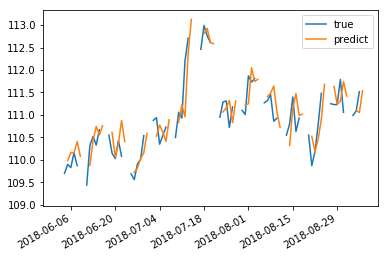

In [12]:
# 正解データと予測データ
correct_2016_year = dataset[dataset.dates > '2018-06-01'].series_data
predict_2016_year = predict_stock_series

print(predict_stock_series)
print(predict_stock_series[:]['end'] - predict_stock_series[:]['start'])

print('PRED : end‐start=', predict_stock_series[-1:]['end'] - predict_stock_series[-1:]['start'])
print('PRED : start=', predict_stock_series[-1:]['start'])
print('PRED : end=', predict_stock_series[-1:]['end'])



#print(predict_stock_series[:-1])
#print(predict_stock_series[:-1]['end'])

#predict_stock_series.to_csv('to_csv_out_20180831fx-601.csv', columns=['始値', '高値', '安値', '終値','出来高', '終値調整','USD','EUR'])
predict_stock_series.to_csv('to_csv_out_20180905fx2015-0601-USD-NOVOL-10000.csv', columns= ['start', 'high', 'low', 'end','adjust','USD'])
for feature in stock_series.columns:
    plot_data = pd.DataFrame({
       'true': correct_2016_year[feature],
       'predict': predict_2016_year[feature]
    }).plot()
#       asFigure = True,
#       title = feature
#   )
    print(len(stock_series.columns),feature)
#   plot_data['layout']['paper_bgcolor'] = '#FFFFFF'
    plot_data.plot()